[参考](https://www.kaggle.com/varunsharma3/credit-card-fraud-detection-using-smote-0-99-auc)。

# 信用卡欺诈检测

探索如何使用 smote、集成技术、交叉评估、kfold和logistic回归来处理倾斜数据集。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
data = pd.read_csv("../input/creditcard.csv")

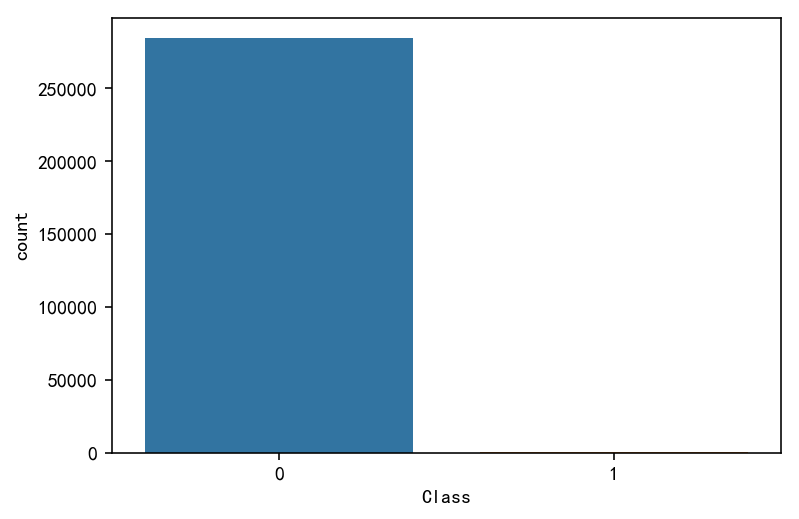

In [3]:
import seaborn as sns

sns.countplot(x='Class', data=data)

不平衡的定义是不到10%的一类和90%的另一类。因此，我们的数据明显有偏差。



规范化“金额”列并删除任何多余的列，即时间和金额。

In [5]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)

正如我们前面提到的，有几种方法可以对倾斜数据重新取样。除了欠采样和过采样之外，还有一种非常流行的方法叫做“合成少数类过采样技术”，它是过采样和欠采样的结合，但过采样方法不是通过复制少数类，而是通过一种算法构造新的少数类数据实例。



在本笔记本中，我们将使用传统的抽样方法。我可能会尝试在将来的代码版本中实现smote，但现在我将使用传统的欠采样。



我们对数据集进行采样的方式是创建50/50的比率。这将通过从多数类中随机选择“x”数量的样本来实现，即“x”为少数类记录的总数。

In [6]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

使用多条线进行窒息练习：这里我们只使用一种imblearn方法进行练习，尝试使用imblearn包中的不同采样技术。

In [7]:
#Apply SMOTE to create synthetic observations from minority class
#Source:https://github.com/scikit-learn-contrib/imbalanced-learn
from imblearn.combine import SMOTETomek  #Over sampling
ee = SMOTETomek()
X_sampled, y_sampled = ee.fit_sample(X, y.values.ravel())
print(type(X_sampled))

#Number of records in original data
print('Total rows in original data:{}'.format(X.shape[0]))

#Percentage of fraudlent records in original data
Source_data_no_fraud_count = len(data[data.Class == 0])
Source_data_fraud_count = len(data[data.Class == 1])
print('Percentage of fraud counts in original dataset:{}%'.format(
    (Source_data_fraud_count * 100) /
    (Source_data_no_fraud_count + Source_data_fraud_count)))

#Number of records in original data
print('Total rows from ensembled data :{}'.format(X_sampled.shape[0]))

#Percentage of fraudlent records in sampled data
Sampled_data_no_fraud_count = len(y_sampled[y_sampled == 0])
Sampled_data_fraud_count = len(y_sampled[y_sampled == 1])
print('Percentage of fraud counts in the new data:{}%'.format(
    (Sampled_data_fraud_count * 100) /
    (Sampled_data_no_fraud_count + Sampled_data_fraud_count)))

<class 'numpy.ndarray'>
Total rows in original data:284807
Percentage of fraud counts in original dataset:0.1727485630620034%
Total rows from ensembled data :568630
Percentage of fraud counts in the new data:50.0%


交叉验证我们需要将培训数据分为培训集和测试集。我们的分类器将在训练集中学习其参数。30%的数据将从培训集中排除并保存在测试集中。

In [9]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled,y_sampled,test_size = 0.3,random_state = 0)
print("")
print("Number transactions train in sampled dataset: ", len(X_train_sampled))
print("Number transactions test in sampled dataset: ", len(X_test_sampled))
print("Total number of transactions: ", len(X_train_sampled)+len(X_test_sampled))

X_train_sampled_df = pd.DataFrame(X_train_sampled)
y_train_sampled_df = pd.DataFrame(y_train_sampled)
X_test_sampled_df = pd.DataFrame(X_test_sampled)
y_test_sampled_df = pd.DataFrame(y_test_sampled)

Number transactions train dataset:  398041
Number transactions test dataset:  170589
Total number of transactions:  568630

Number transactions train in sampled dataset:  398041
Number transactions test in sampled dataset:  170589
Total number of transactions:  568630


逻辑回归分类器-欠采样数据

我们对召回分数非常感兴趣，因为这是一个有助于我们尝试捕捉最欺诈交易的指标。如果您认为精确性、精确性和召回对混淆矩阵的作用，那么召回将是最有趣的：

准确度=（tp+tn）/总计

精度=tp/（tp+fp）

召回=tp/（tp+fn）

正如我们所知，由于数据的嵌入，许多观察结果可以被预测为假阴性，也就是说，我们预测一个正常的交易，但实际上这是一个欺诈的交易。回忆捕捉到了这一点。

显然，试图增加回忆，往往伴随着精度的降低。然而，在我们的案例中，如果我们预测一笔交易是欺诈性的，而事实证明并非如此，那么与之相反，这并不是一个巨大的问题。

我们甚至可以在对每种类型的错误使用不同权重的FN和FP时应用成本函数，但现在我们将其放在一边。

我们将使用KFOLD来识别物流分类器的光学配置。



将数据分为5层。定义要使用的不同参数值，即每个参数值的C_param_范围进行迭代。在每次迭代中，我们将用不同的数据范围进行5次迭代，并计算出它们的得分。对于每个迭代，我们将计算平均分数。一旦我们知道了每个迭代的得分，我们就可以确定5个迭代中的最大得分是多少。然后，我们使用相应的配置值作为最佳配置值。

该值将用于在下一步中设置模型。

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

创建一个函数来绘制一个奇特的混淆矩阵。或者，在本地计算机上，您可以使用更简单的方法来使用具有API的python_ml包，以便轻松创建混淆矩阵。

In [13]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

测试集和绘图混淆矩阵的预测
我们一直在讨论使用召回度量作为我们预测模型有效性的代理。尽管召回仍然是我们想要计算的召回，但请记住，欠采样数据没有对某个类产生偏差，这不会使召回度量成为关键。

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset: 91.62227659599377%


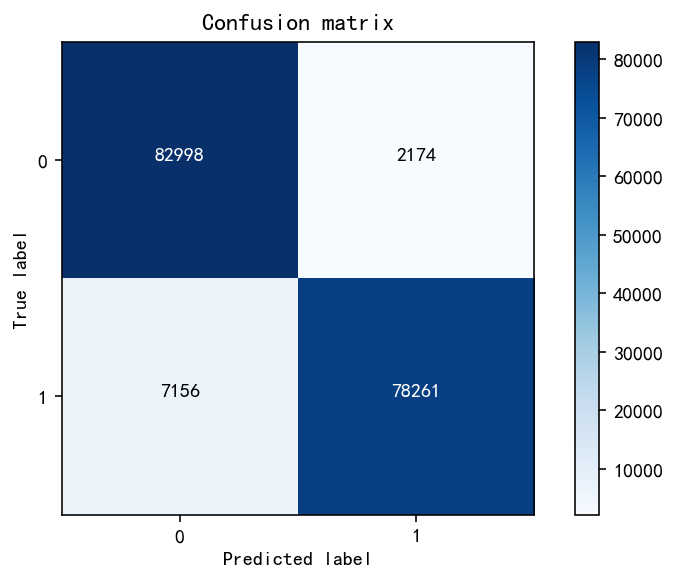

In [15]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = 10.0, penalty = 'l1')
lr.fit(X_train_sampled_df,y_train_sampled_df.values.ravel())
y_pred_sample = lr.predict(X_test_sampled_df.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_sampled_df,y_pred_sample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

该模型对广义看不见的数据（测试集）提供了91.65％的召回准确率。第一次尝试的比例不错。但是，回想一下，在采样测试集上，这是一个91.65％的召回准确度度量。现在，让我们应用我们拟合的模型并在整个数据上进行测试。

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:91.62227659599377% 


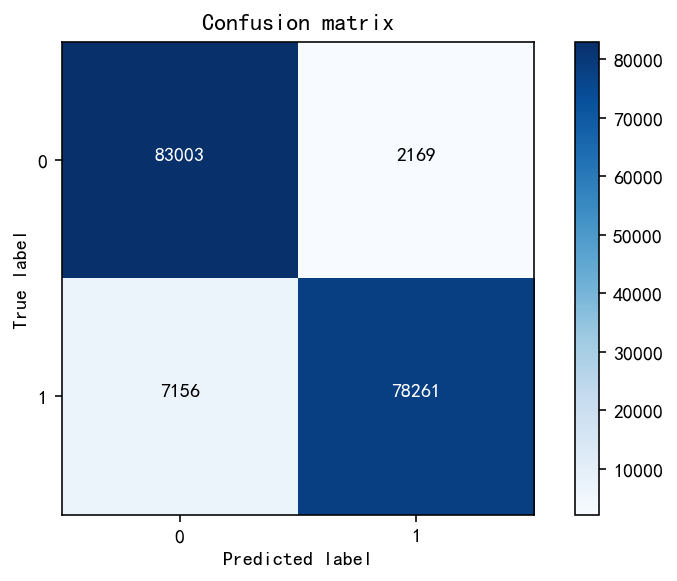

In [16]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = 10.0, penalty = 'l1')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset:{}% ".format(100*(cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

将其应用于更大且偏斜的数据集时，仍然具有非常不错的回忆精度！
我们可以开始对初始方法的工作方式感到满意。
绘制ROC曲线和Precision-Recall曲线。
在这种情况下，我发现精确回忆曲线更加方便，因为我们的问题依赖于“正”类比负类更有趣，但是由于我们已经计算了回忆精度，我不打算绘制精确回忆曲线。

AUC和ROC曲线也很有趣，可以检查模型是否也正确地预测并且没有造成很多错误

AUC（曲线下面积）得分越高越好。它量化了一个测量。

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


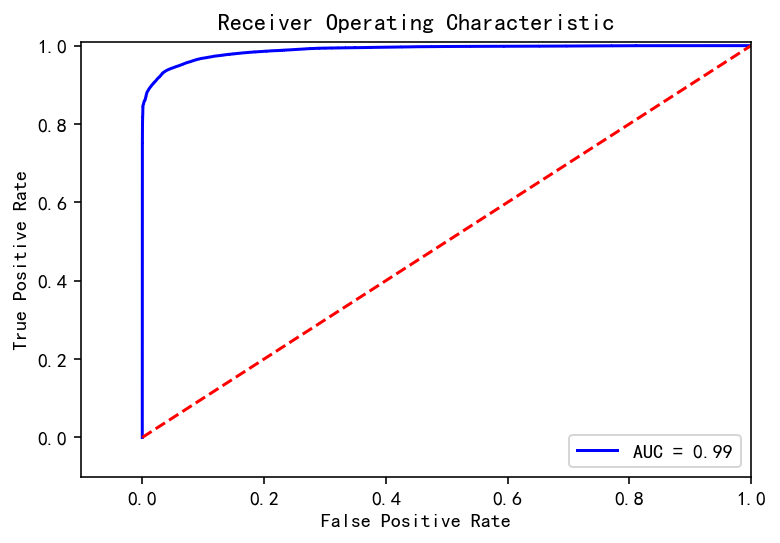

In [17]:
# ROC CURVE
lr = LogisticRegression(C = 10.0, penalty = 'l1')
temp = lr.fit(X_train,y_train)

y_pred_sampled_score= temp.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred_sampled_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

另一个有趣的注释是初始化多个欠采样数据集并在循环中重复该过程。请记住，为了创建欠采样数据，我们随机从大多数类中获取记录。虽然这是一种有效的技术，但并不代表真实的人口，因此用不同的欠采样配置重复该过程并检查先前选择的参数是否仍然是最有效的将是有趣的。最后，我们的想法是使用整个数据集的更广泛的随机表示，并依赖于平均的最佳参数。

In [18]:
from sklearn.metrics import recall_score

recall_score(y_test,y_pred)  

0.9162227659599377

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
predictions = rf.predict(X_test)

In [22]:
# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [23]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]
layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')